**Оформление ДЗ**:

- Выполненное ДЗ сохраните в файл ``ml_b2c2025q2_<фамилия>_<имя>_HW07.ipynb`` (пример ``ml_b2c2025q2_Dral_Alexey_HW07.ipynb``)
- Открыть форму сдачи ДЗ:[ML-B2C-2025-Q2](https://www.google.com/url?q=https%3A%2F%2Fforms.gle%2F1cS6HPGgvdSzPfuc9)
- Выбрать задание HW07: ML Transformers
- Указать ваш логин на образовательной платформе (логин EDX)
- Загрузить файл с решением ``

**Дополнительные ссылки**
- Настройка локального окружения: https://github.com/big-data-team/ml-course
- Датасеты UCI: https://archive.ics.uci.edu/

**Вопросы**:
- Свои вопросы присылайте в Телеграм.

**Фидбек**:
- Пожалуйста, оставьте свой отзыв после выполнения домашнего задания по ссылке:

    https://forms.gle/GnuG1EpcgQd1wRdV7

## Вопросы на понимание (10%)

1. Почему в автоэнкодерах не обязательно использование валидационной выборки?
2. Что произойдет с вариативным автоэнкодером, если убрать регуляризацию через KL-дивергенцию?
3. Допустим что при тренировке GAN модели, генератор обучается быстрее дискриминатора. Что произойдет с моделью?
4. Как выглядят процесс обучения и процесс генерации в диффузионных моделях?
5. Как считается мера ошибки при обучении CLIP?

## Конволюционные автоэнкодеры (30%)

Напишите вариант автоэнкодера для датасета MNIST, который будет использовать сверточные слои.

Для декодера вам пригодится слой `Conv2DTranspose`, который выполняет обратную операцию свертки.


Как вы оцените качество компрессии этой модели по сравнению с обычным полносвязным автоэнкодером? Какую модель Вы бы использовали для задачи сжатия изображений? Почему?

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"


In [10]:
def get_dataloaders(batch_size: int = 128, num_workers: int = 2):
    tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_ds = datasets.MNIST(root="data", train=True,  download=True, transform=tf)
    test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=tf)

    # вал-сплит 54 000 / 6 000
    train_ds, val_ds = torch.utils.data.random_split(
        train_ds, [54_000, 6_000], generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_ds, batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader


In [11]:

class ConvAE(nn.Module):
    def __init__(self, latent_dim: int = 16):
        super().__init__()
        # encoder
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),         # 28×28 → 14×14
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 2, 1),        # 14×14 → 7×7
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(64*7*7, latent_dim)
        )
        # decoder
        self.dec_fc = nn.Linear(latent_dim, 64*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1), # 7×7 → 14×14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 3, 2, 1, output_padding=1),  # 14×14 → 28×28
            nn.Tanh()
        )

    def forward(self, x):
        z = self.enc(x)
        x_hat = self.dec(self.dec_fc(z).view(-1, 64, 7, 7))
        return x_hat


In [12]:

def train_autoencoder(epochs=10, latent_dim=16):
    model = ConvAE(latent_dim).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
    crit  = nn.MSELoss()
    tl, vl, _ = get_dataloaders()

    for epoch in range(epochs):
        model.train()
        for x, _ in tqdm(tl, leave=False):
            x = x.to(device)
            opt.zero_grad()
            loss = crit(model(x), x)
            loss.backward(); opt.step()

        # валидация
        model.eval()
        with torch.no_grad():
            v_loss = sum(crit(model(x.to(device)), x.to(device)).item() for x, _ in vl)/len(vl)
        print(f"epoch {epoch+1:02d}/{epochs}  val_loss={v_loss:.4f}")
    return model

conv_ae = train_autoencoder(epochs=8)


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 01/8  val_loss=0.0733


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 02/8  val_loss=0.0578


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 03/8  val_loss=0.0506


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 04/8  val_loss=0.0460


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 05/8  val_loss=0.0436


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 06/8  val_loss=0.0418


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 07/8  val_loss=0.0404


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 08/8  val_loss=0.0396


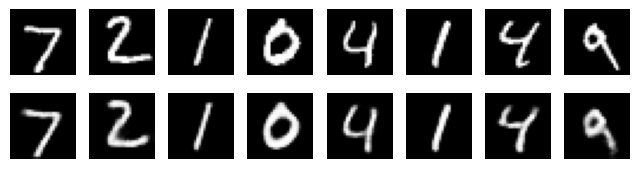

In [13]:

def show_reconstructions(model, n=8):
    model.eval()
    _, _, test_loader = get_dataloaders(batch_size=n)
    x, _ = next(iter(test_loader))
    with torch.no_grad():
        x_hat = model(x.to(device)).cpu()

    plt.figure(figsize=(n, 2))
    for i in range(n):
        plt.subplot(2, n, i+1);       plt.imshow(x[i,0],     cmap="gray"); plt.axis("off")
        plt.subplot(2, n, n+i+1);     plt.imshow(x_hat[i,0], cmap="gray"); plt.axis("off")
    plt.show()

show_reconstructions(conv_ae)


## Вариативные автоэнкодеры (45%)

![img](https://www.researchgate.net/publication/365190062/figure/fig2/AS:11431281095388874@1667878234857/Structure-of-the-conditional-variational-autoencoder-CVAE.png)

Воспользуйтесь кодом из семинара (либо конволюционными автоэнкодером из прошого задания) и добавьте условия на вариативные автоэнкодеры.

1. В качестве условия используйте метки классов.
2. В энкодер и декодер добавьте условия на метки классов.


Проверьте качество модели и сравните с обычным вариативным автоэнкодером.

In [14]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, hidden_dim: int = 2):
        super().__init__()
        self.fc_enc = nn.Sequential(
            nn.Linear(28*28, 400), nn.ReLU(),
        )
        self.mu  = nn.Linear(400, hidden_dim)
        self.log = nn.Linear(400, hidden_dim)

        self.fc_dec = nn.Sequential(
            nn.Linear(hidden_dim, 400), nn.ReLU(),
            nn.Linear(400, 28*28), nn.Sigmoid()
        )

    def encode(self, x):
        h = self.fc_enc(x)
        return self.mu(h), self.log(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.fc_dec(z)
        return recon, mu, logvar


In [16]:
model = VariationalAutoEncoder(hidden_dim=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loader, val_loader, _ = get_dataloaders()

def vae_loss(recon_x, x, mu, logvar):
    bce = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (bce + kld) / x.size(0)

for epoch in range(10):
    model.train()
    for x, _ in tqdm(train_loader, leave=False):
        x = x.to(device)
        x01 = (x + 1) / 2

        recon, mu, logvar = model(x01)
        loss = vae_loss(recon, x01, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch+1}: loss {loss.item():.4f}")


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 1: loss 147.8665


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 2: loss 138.2866


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 3: loss 133.3457


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 4: loss 130.9335


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 5: loss 128.7422


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 6: loss 128.8134


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 7: loss 130.7120


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 8: loss 123.4594


  0%|          | 0/422 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d99b4166ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d99b4166ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

epoch 9: loss 130.3316


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 10: loss 135.3380


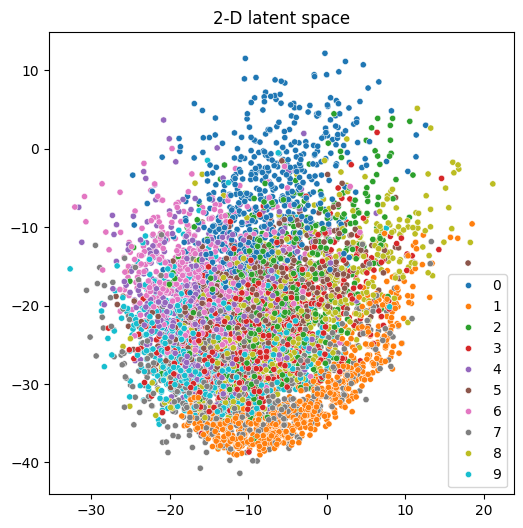

In [17]:
import seaborn as sns
model.eval()
emb, lab = [], []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        z, _ = model.encode(x.view(-1, 28*28))
        emb.append(z.cpu()); lab.append(y)
emb = torch.cat(emb).numpy(); lab = torch.cat(lab).numpy()

plt.figure(figsize=(6,6))
sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=lab, palette="tab10", s=20)
plt.title("2-D latent space"); plt.show()



## GAN с условием (15%)

Воспользуйтесь кодом ниже и добавьте условия в GAN модели.

1. В качестве условия используйте метки классов.
2. В генератор и дискриминатор добавьте условия на метки классов.

Проверьте качество модели и сравните с остальными моделями. Какую модель вы бы выбрали для работы с генерацией картинок MNIST и почему?

In [19]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, num_classes=10, img_shape=(1,28,28)):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.init = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )
        self.img_shape = img_shape

    def forward(self, z, y):
        x = torch.cat([z, self.label_emb(y)], dim=1)
        img = self.init(x)
        return img.view(img.size(0), *self.img_shape)


class Discriminator(nn.Module):
    def __init__(self, num_classes=10, img_shape=(1,28,28)):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.net = nn.Sequential(
            nn.Linear(np.prod(img_shape) + num_classes, 512),
            nn.LeakyReLU(0.2, True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, y):
        d_in = torch.cat([img.view(img.size(0), -1), self.label_emb(y)], dim=1)
        validity = self.net(d_in)
        return validity


In [21]:
z_dim = 100
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

train_loader, _, _ = get_dataloaders(batch_size=128)

for epoch in range(15):
    for real, labels in tqdm(train_loader, leave=False):
        b = real.size(0)
        real, labels = real.to(device), labels.to(device)

        # === Train Discriminator ===
        z = torch.randn(b, z_dim, device=device)
        fake = G(z, labels).detach()
        loss_D = (
            criterion(D(real,  labels), torch.ones(b,1, device=device)) +
            criterion(D(fake,  labels), torch.zeros(b,1,device=device))
        ) / 2
        opt_D.zero_grad(); loss_D.backward(); opt_D.step()

        # === Train Generator ===
        z = torch.randn(b, z_dim, device=device)
        fake = G(z, labels)
        loss_G = criterion(D(fake, labels), torch.ones(b,1,device=device))
        opt_G.zero_grad(); loss_G.backward(); opt_G.step()

    print(f"epoch {epoch+1:02d} | D {loss_D.item():.3f} | G {loss_G.item():.3f}")


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 01 | D 0.370 | G 2.283


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 02 | D 0.167 | G 3.347


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 03 | D 0.164 | G 3.057


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 04 | D 0.054 | G 5.226


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 05 | D 0.126 | G 2.840


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 06 | D 0.154 | G 3.435


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 07 | D 0.132 | G 4.011


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 08 | D 0.028 | G 4.788


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 09 | D 0.011 | G 6.818


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 10 | D 0.000 | G 7.899


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 11 | D 0.000 | G 8.609


  0%|          | 0/422 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d99b4166ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d99b4166ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

epoch 12 | D 0.000 | G 9.481


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 13 | D 0.000 | G 8.926


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 14 | D 0.000 | G 10.372


  0%|          | 0/422 [00:00<?, ?it/s]

epoch 15 | D 0.000 | G 10.904


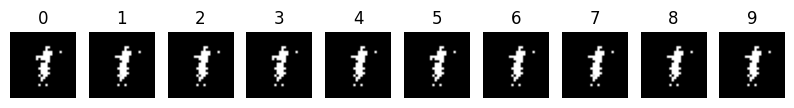

In [22]:
G.eval()
rows = list(range(10))
with torch.no_grad():
    z = torch.randn(10, z_dim, device=device)
    samples = G(z, torch.arange(10, device=device)).cpu()

plt.figure(figsize=(10,2))
for i in rows:
    plt.subplot(1,10,i+1)
    plt.imshow(samples[i,0]*0.5+0.5, cmap="gray"); plt.axis("off"); plt.title(i)
plt.show()


## Решил ДЗ - дай обратную связь ;)

Надеемся, было интересно и полезно.

Пожалуйста, оставьте обратную связь по этому домашнему заданию: https://forms.gle/GnuG1EpcgQd1wRdV7